<a href="https://colab.research.google.com/github/DevenMittal/KPMG-LLM-Energy-Consumption-and-Sustainabiility/blob/main/KPMG1B_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# =====================================================================================
#KPMG AI Studio - Team 1B
#Members: Michelle Garcia, Ruth Chane, Krish Garg, Harsharandeep Dhillon, Deven Mittal
# =====================================================================================

# Colab: install deps
!pip -q install --upgrade huggingface_hub datasets pandas matplotlib pyarrow fastparquet

from huggingface_hub import snapshot_download
import pandas as pd, os, glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


local_dir = snapshot_download(
    repo_id="ejhusom/llm-inference-energy-consumption",
    repo_type="dataset",
    allow_patterns=["data/*.csv", "README.md"]
)

csv_paths = sorted(glob.glob(os.path.join(local_dir, "data", "*.csv")))
len(csv_paths), csv_paths[:3]


In [ ]:
#loading all the CSVs into one df
dfs = []
for p in csv_paths:
    try:
        df = pd.read_csv(p)
        df["__source_file"] = os.path.basename(p)
        dfs.append(df)
    except Exception as e:
        print("Failed to read", p, e)

df = pd.concat(dfs, ignore_index=True)
#drop junk

cols_to_drop = ["Unnamed: 0", "Unnamed: 0.1", "Unnamed: 0.2", "index"  ]
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors="ignore")

#drop rows missing any of these key information
required_cols = ["model_name", "energy_consumption_llm_total", "response_token_length"]
df = df.dropna(subset=[c for c in required_cols if c in df.columns])

print("Rows:", len(df))
df.head(5)


In [ ]:
df.info()
print("\nColumns:", list(df.columns))
print("\nSample unique values by some likely metadata columns (if present):")
for col in ["model", "model_name", "hardware", "prompt_dataset", "dataset", "__source_file"]:
    if col in df.columns:
        print(col, "→", df[col].dropna().unique()[:8])

#drop rows where prompt_token_length is missing
df = df.dropna(subset=["prompt_token_length"])

#  drop rows where response_token_length is 0 or prompt_token_length is 0 because these will break energy_per_token later
df = df[(df["response_token_length"] > 0) & (df["prompt_token_length"] > 0)]
print("Rows after cleaning:", len(df))

#keep only columns we will actually use
keep_cols = [
    "model_name",
    "created_at", "start_time", "end_time",
    "prompt_token_length", "response_token_length",
    "word_count", "sentence_count", "avg_word_length",
    "word_diversity", "flesch_kincaid_grade",
    "energy_consumption_llm_total",
    "total_duration", "prompt_duration", "response_duration",
    "__source_file"
]

df = df[[c for c in keep_cols if c in df.columns]].copy()
print("Shape after column reduction:", df.shape)
df.head()


In [ ]:


# converting timestamps
df['created_at'] = pd.to_datetime(df['created_at'])
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])

df[['model_name', 'energy_consumption_llm_total', 'prompt_token_length', 'response_token_length']].isna().sum()


In [ ]:
#computing energy in watt-hours
df['energy_Wh'] = df['energy_consumption_llm_total'] * 1000

#computing energy per token and per second
df['energy_Wh_per_token'] = df['energy_Wh'] / (df['response_token_length'].replace(0, np.nan))
df['energy_W'] = df['energy_Wh'] / (df['response_duration'].replace(0, np.nan) / 3600)
GRID_G_CO2_PER_KWH = 400  # --> this varies depending on the region/country (i think US is 380 ish, so should still be acc)
PUE = 1.2

df['co2_g'] = df['energy_Wh'] / 1000 * GRID_G_CO2_PER_KWH * PUE

#ConvertS energy use into estimated electricity cost (in USD)
df['cost_usd'] = df['energy_Wh'] / 1000 * 0.12   # 12 cents per kWh

#Calculate ROI as number of tokens generated per $1
df['roi_tokens_per_dollar'] = df['response_token_length'] / df['cost_usd'].replace(0, np.nan)


df[['model_name','energy_Wh','energy_Wh_per_token','energy_W']].describe()

#CreateS summary table grouped by model with all key metrics
df_summary = df.groupby('model_name')[ ['energy_Wh', 'co2_g', 'cost_usd', 'energy_Wh_per_token', 'roi_tokens_per_dollar']].mean().reset_index()
df_summary
df_summary.to_csv("summary_data.csv", index=False)



In [ ]:
summary = (
    df.groupby('model_name')[['energy_Wh','energy_Wh_per_token','response_token_length','response_duration']]
      .agg(['mean','median','std','count'])
      .sort_values(('energy_Wh','mean'))
)
summary.head(10)


In [ ]:
plt.figure(figsize=(10,5))
df.boxplot(column='energy_Wh_per_token', by='model_name', rot=45)
plt.title('Energy per Output Token by Model')
plt.ylabel('Wh per token')
plt.suptitle('')
plt.show()


The above plot tells us that larger models consume more energy per token as seen with codellama and llama3 70b. Bigger models do have more parameters so it requires more GPU mem so more energy would be needed to generate each token.  

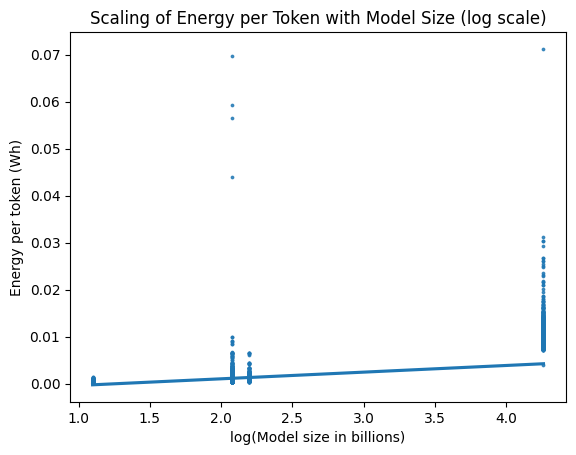

In [ ]:


size_map = {'gemma:2b': 2, 'gemma:7b': 7, 'codellama:7b': 7, 'codellama:70b': 70, 'llama3': 8, 'llama3:70b': 70}
df['model_size_b'] = df['model_name'].map(size_map)

sns.regplot(x=np.log1p(df['model_size_b']), y=df['energy_Wh_per_token'], scatter_kws={'s':3})
plt.title("Scaling of Energy per Token with Model Size (log scale)")
plt.xlabel("log(Model size in billions)")
plt.ylabel("Energy per token (Wh)")
plt.show()


the plot above shows that energy per token grown sublinearly with model size. this is what the papers/readings have already expressed, this further proves it.

In [ ]:
#correlation between prompt length / complexity and energy
cols_of_interest = [
    'prompt_token_length', 'word_count', 'sentence_count',
    'avg_word_length', 'word_diversity', 'flesch_kincaid_grade',
    'energy_Wh'
]
corr = df[cols_of_interest].corr()['energy_Wh'].sort_values(ascending=False)
corr


,energy_Wh
energy_Wh,1.000000
prompt_token_length,0.075086
word_count,0.067790
sentence_count,0.059407
avg_word_length,0.031050
flesch_kincaid_grade,0.026518
word_diversity,-0.031502


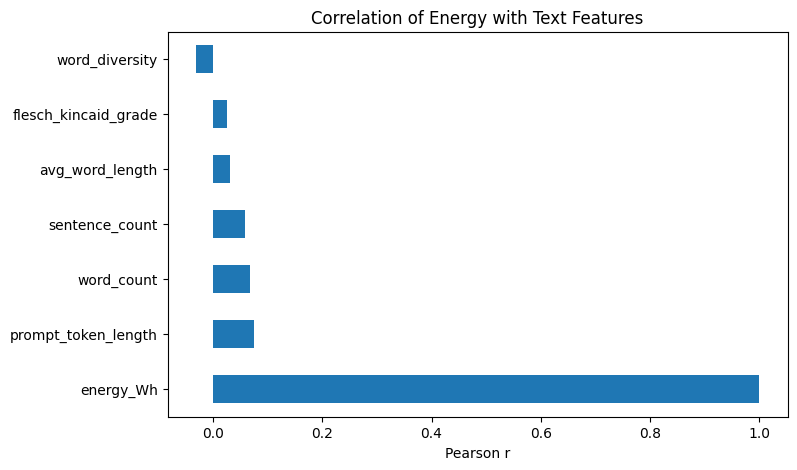

In [ ]:
plt.figure(figsize=(8,5))
corr.dropna().plot(kind='barh')
plt.title('Correlation of Energy with Text Features')
plt.xlabel('Pearson r')
plt.show()


The above plot tells us that energy usage during inference doesn't scale linearly with text complexity, word diversity, or readability measured.

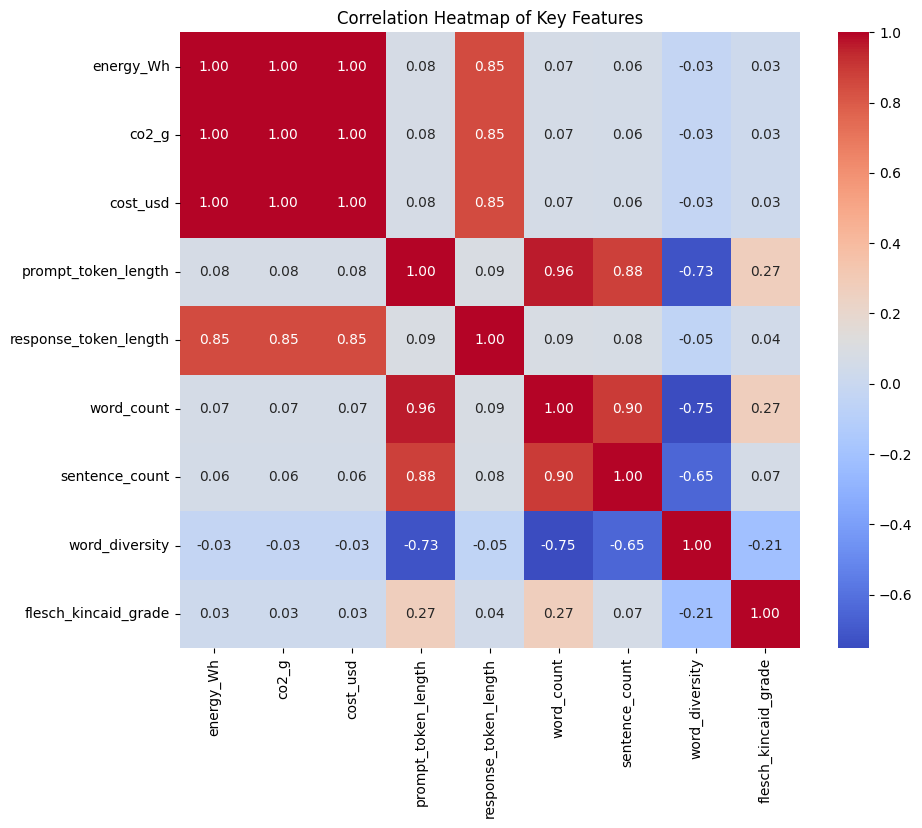

In [ ]:
#Correlation heatmap

plt.figure(figsize=(10,8))
corr_matrix = df[['energy_Wh','co2_g','cost_usd','prompt_token_length','response_token_length',
                  'word_count','sentence_count','word_diversity','flesch_kincaid_grade']].corr()

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Key Features")
plt.show()


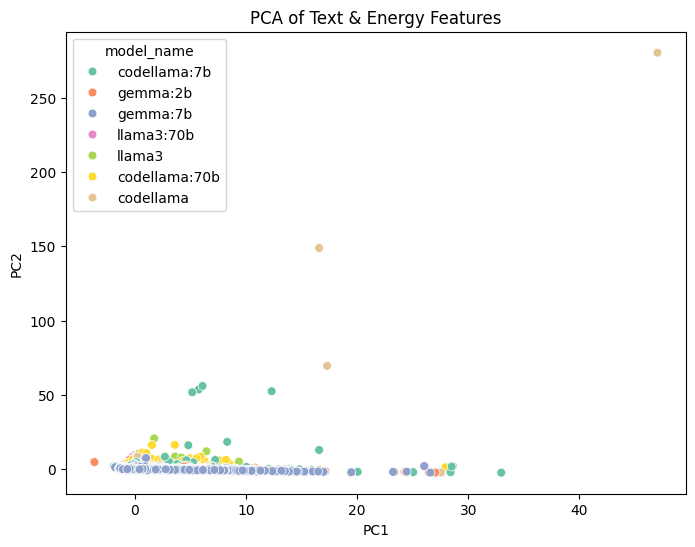

In [ ]:
#Principal Component Analysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#Numeric columns for PCA

pca_cols = ['prompt_token_length', 'response_token_length', 'word_count',
            'sentence_count', 'avg_word_length', 'word_diversity',
            'flesch_kincaid_grade', 'energy_Wh']
X = df[pca_cols].dropna()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

# Store in dataframe for plotting
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['model_name'] = df.loc[X.index, 'model_name']

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x='PC1', y='PC2', hue='model_name', data=pca_df, palette='Set2', s=40)
plt.title("PCA of Text & Energy Features")
plt.show()


This indicates that the primary source of variation (PC1) is driven by energy-related differences among model architectures and sizes rather than by linguistic complexity. Larger and more computationally intensive models tend to consume more energy, while text structure and readability features have minimal independent influence.



R² Score: 0.368
RMSE: 1.021


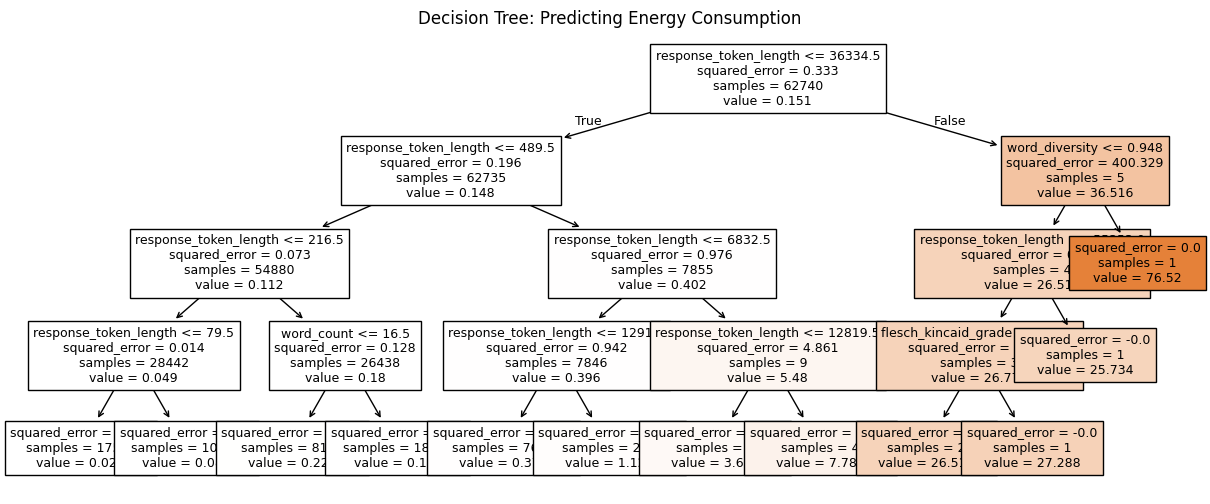

In [ ]:
#Decision Tree

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import r2_score, mean_squared_error

# Define features and target
features = ['prompt_token_length','response_token_length','word_count','sentence_count',
            'avg_word_length','word_diversity','flesch_kincaid_grade']
target = 'energy_Wh'

X = df[features].fillna(0)
y = df[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = DecisionTreeRegressor(max_depth=4, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")

# Plot tree
plt.figure(figsize=(15,6))
plot_tree(model, feature_names=features, filled=True, fontsize=9)
plt.title("Decision Tree: Predicting Energy Consumption")
plt.show()


The response token length is the strongest driver of energy consumption across all models. The first several splits of the tree are based entirely on token length showing that longer responses directly increase energy usage due to higher computational demands.

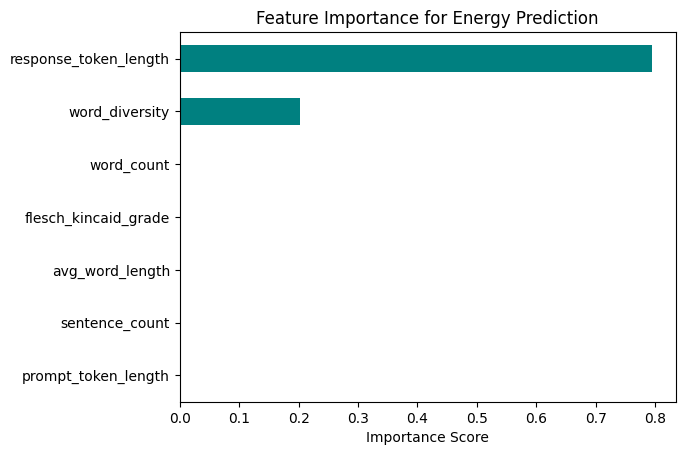

In [ ]:
# Feature importance plot
importances = pd.Series(model.feature_importances_, index=features)
importances.sort_values().plot(kind='barh', color='teal')
plt.title('Feature Importance for Energy Prediction')
plt.xlabel('Importance Score')
plt.show()


The feature importance chart gives us  proof that energy consumption is overwhelmingly driven by response length, while linguistic complexity plays almost no role.

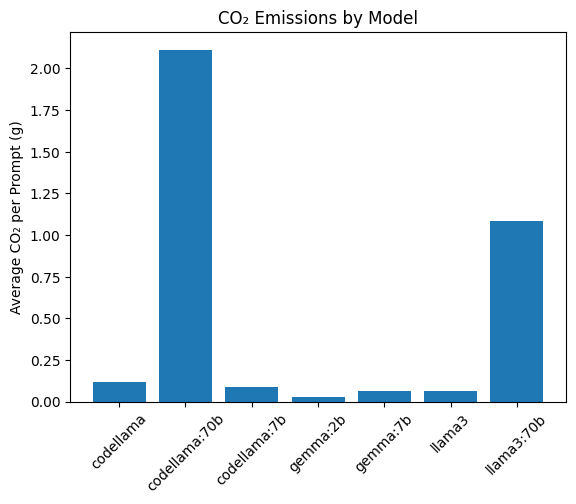

In [ ]:


plt.bar(df_summary['model_name'], df_summary['co2_g'])
plt.xticks(rotation=45)
plt.ylabel('Average CO₂ per Prompt (g)')
plt.title('CO₂ Emissions by Model')
plt.show()


In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=roi_dashboard_df.sort_values("cost_usd", ascending=False),
            x="cost_usd", y="model_name")
plt.title("Average Cost (USD) per Model")
plt.xlabel("Cost (USD)")
plt.ylabel("Model")
plt.tight_layout()
plt.show()

NameError: name 'roi_dashboard_df' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:
#ROI-tokens per dollar

plt.figure(figsize=(10, 6))
sns.barplot(data=df_summary.sort_values("roi_tokens_per_dollar", ascending=False),
            x="roi_tokens_per_dollar", y="model_name")
plt.title("ROI: Tokens per Dollar Spent")
plt.xlabel("Tokens per $1")
plt.ylabel("Model")
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(df_summary["cost_usd"], df_summary["co2_g"])

# Adds model name labels
for i, row in df_summary.iterrows():
    plt.text(row["cost_usd"], row["co2_g"], row["model_name"], fontsize=9)

plt.xlabel("Cost (USD)")
plt.ylabel("Total CO₂ Emissions (g)")
plt.title("Cost vs CO₂ Emissions by Model")
plt.grid(True)
plt.tight_layout()
plt.show()
